# Conversation AI Toxic Comment Classification Challenge

Looking at comments pulled from Wikipedia, classify comments into any (or none) of the following categories: 
Toxic, Severe Toxic, Obscene, Threat, Insult, Identity Hate

In [2]:
import numpy as np 
import pandas as pd
import nltk
nltk.download('stopwords')
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
stopwords_set = set(stopwords.words('english'))
nltk.download('punkt')

import os


MAX_FEATURES = 20000
EMBEDDING_SIZE = 300



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
#Let us take a took at the training data
train_df.iloc[:,1:]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
# Look for null values
print(train_df.isnull().any())
print(test_df.isnull().any())

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool
id              False
comment_text    False
dtype: bool


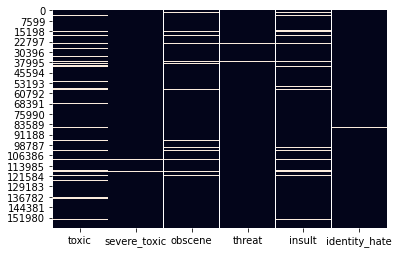

In [6]:
# Look at the frequency of occurence of tags in dataset
sns.heatmap(train_df.iloc[:,2:] == 1, cbar = False)

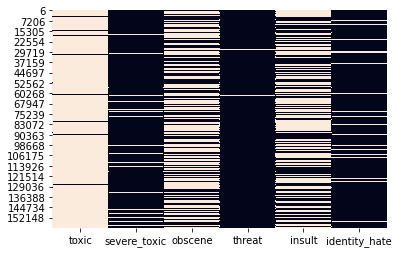

In [7]:
# Look at the frequency of tags within subset of dataset with toxic comments
sns.heatmap(train_df.iloc[np.unique(np.where(train_df.iloc[:,2:] == 1)[0]),2:] == 1, cbar = False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


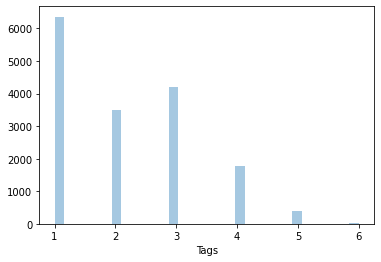

In [8]:
# Check to see if several tags may co-occur
train_df['Tags'] = 0
for tag in train_df.columns.values[2:-1]:
    train_df['Tags'] += train_df[tag]
sns.distplot(train_df.loc[train_df['Tags'] != 0]['Tags'], hist = True, kde = False)

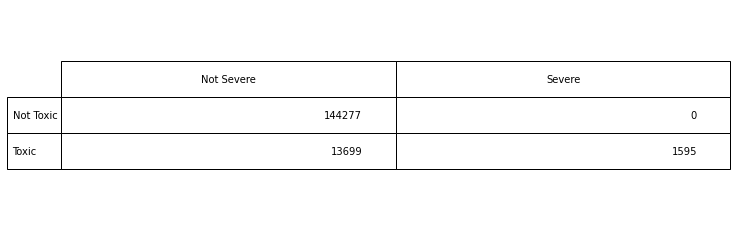

In [9]:
# Investigate the relationship between Severely Toxic Comments and Toxic Comments
table = plt.table(confusion_matrix(train_df['toxic'], train_df['severe_toxic']), loc = 'center', colLabels = ['Not Severe', 'Severe'], rowLabels = ['Not Toxic', 'Toxic'])
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on = None)
table.scale(2,3)
plt.show()

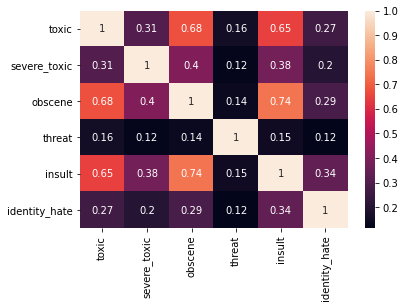

In [10]:
# Look at correlation to get a better sense of the coocurrence of tags
sns.heatmap(train_df.iloc[:,2:-1].corr(), annot = True)

In [11]:
# Notice some key words will be lost and there are stylistic features of profanity
train_df.loc[(train_df['Tags'] != 0) & (train_df['comment_text'].str.contains('@'))]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Tags
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
238,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1,4
437,011d0c0a6c8e5765,I NEVER FUCKING MADE THIS MOTHER FUCKING ARTIC...,1,0,1,0,1,0,3
638,01b9aa85cc61c03f,"""\n\n You Suck \n\nIf you don't undelete the p...",1,0,1,0,1,0,3
2094,05a928e4d2101d4e,@: nobody cares about the Fucking Shit like yo...,1,1,1,0,1,0,4
...,...,...,...,...,...,...,...,...,...
151182,78dccc43b8d7a000,"do you think that i am a fool, you tryin to pl...",1,0,1,0,1,0,3
154518,af0a6e1bec14c8bc,Then Get rid of the skys the limit biggie stuf...,1,0,0,0,0,0,1
154940,b676472355221ade,"""\n\nAwww thats cute Magog but lets get real D...",1,0,1,0,0,0,2
157585,e08d6e1a6db20c1f,nope... \n\nNO i do NOT fucing think so!!!!!\n...,1,0,1,0,0,0,2


In [12]:
# Count the number of '!', '@' and '$' as perhaps a useful predictor (short coming of not using n-gram)
train_df['!'] = train_df["comment_text"].str.count('!')
train_df['@$'] = train_df["comment_text"].str.count('@') + train_df["comment_text"].str.count('$')
test_df['!'] = test_df["comment_text"].str.count('!')
test_df['@$'] = test_df["comment_text"].str.count('@') + test_df["comment_text"].str.count('$')
train_x_eng = np.column_stack([train_df['!'],train_df['@$']])
test_x_eng = np.column_stack([test_df['!'],test_df['@$']])
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Tags,!,@$
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,1,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0,0,1
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0,0,1
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0,0,1
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0,0,1


In [13]:
# Check to see if there is any pattern in most common words from toxic comments that must be taken into consideration before parsing
all_text = ' '.join([word for word in ' '.join(train_df.loc[train_df['Tags'] != 0]['comment_text']).split() if word not in stopwords_set])
wordcloud = WordCloud().generate(all_text)
#plt.figure(figsize = (8, 8), facecolor = None) 
#plt.imshow(wordcloud) 
#plt.axis("off") 
#plt.tight_layout(pad = 0) 

#plt.show() 

The above cell has been commented out due to profanity

In [14]:
def text_prepare(text):
    """Tokenization and Preprocessing."""
    
    # Make everything lowercase
    text = text.lower()
    
    # To deal with words not in Google Word2Vec Embeddings (probably not terrible significant)
    text = re.sub("doesnt", "does not", text)
    text = re.sub("doesn't", "does not", text)
    text = re.sub("dont", "do not", text)
    text = re.sub("don't", "do not", text)
    text = re.sub("isnt", "is not", text)
    text = re.sub("isn't", "is not", text)
    text = re.sub("wasnt", "was not", text)
    text = re.sub("wasn't", "was not", text)
    text = re.sub("didnt", "did not", text)
    text = re.sub("didn't", "did not", text)
    text = re.sub("behaviour", "behavior", text)
    text = re.sub("colour", "color", text)
    
    # Replace symbols,newline characters and remove stopwords. Then tokenize sentence 
    replace_by_space_re = re.compile('[/(){}\[\]\|@,;#\+_]')
    good_symbols_re = re.compile('[^0-9a-z ]')
    text = re.sub("\n", " ", text)
    text = replace_by_space_re.sub(' ', text)
    text = good_symbols_re.sub('', text)
    text = [x for x in nltk_tokenize(text) if x and x not in stopwords_set]
    
    return text


def nltk_tokenize(text):
    """Used to split a sentence into tokens"""
    
    tokens = word_tokenize(text)
    return tokens


In [15]:
# Clean comments in our training set and test set
train_x = train_df.iloc[:,1:2]
train_y = train_df.iloc[:,2:-3]
test_x = test_df.iloc[:,1:2]
train_cleaned_x = train_x['comment_text'].map(lambda x: text_prepare(x))
test_cleaned_x = test_x['comment_text'].map(lambda x: text_prepare(x))

In [16]:
train_cleaned_x

0         [explanation, edits, made, username, hardcore,...
1         [daww, matches, background, color, im, seeming...
2         [hey, man, im, really, trying, edit, war, guy,...
3         [cant, make, real, suggestions, improvement, w...
4                [sir, hero, chance, remember, page, thats]
                                ...                        
159566    [second, time, asking, view, completely, contr...
159567    [ashamed, horrible, thing, put, talk, page, 12...
159568    [spitzer, umm, theres, actual, article, prosti...
159569    [looks, like, actually, put, speedy, first, ve...
159570    [really, think, understand, came, idea, bad, r...
Name: comment_text, Length: 159571, dtype: object

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Use keras tokenizer to find 20,000 most important words and prepare for them to be fed into embedding layer
tokenizer = Tokenizer(MAX_FEATURES)
tokenizer.fit_on_texts(list(train_cleaned_x))
tokenizer.word_index

{'article': 1,
 'page': 2,
 'wikipedia': 3,
 'talk': 4,
 'please': 5,
 'would': 6,
 'one': 7,
 'like': 8,
 'see': 9,
 'also': 10,
 'think': 11,
 'im': 12,
 'know': 13,
 'people': 14,
 'edit': 15,
 'articles': 16,
 'use': 17,
 'may': 18,
 'time': 19,
 'thanks': 20,
 'even': 21,
 'get': 22,
 'make': 23,
 'good': 24,
 'information': 25,
 'could': 26,
 'well': 27,
 'want': 28,
 'deletion': 29,
 'sources': 30,
 'way': 31,
 'name': 32,
 'pages': 33,
 'first': 34,
 'new': 35,
 'help': 36,
 'editing': 37,
 'source': 38,
 'user': 39,
 'go': 40,
 'need': 41,
 'say': 42,
 'section': 43,
 'edits': 44,
 'thank': 45,
 'made': 46,
 'many': 47,
 'much': 48,
 'really': 49,
 'used': 50,
 'discussion': 51,
 'find': 52,
 'ive': 53,
 'deleted': 54,
 'fuck': 55,
 'work': 56,
 'since': 57,
 'point': 58,
 'right': 59,
 'add': 60,
 'look': 61,
 'read': 62,
 'image': 63,
 'take': 64,
 'still': 65,
 'someone': 66,
 'two': 67,
 'back': 68,
 'fact': 69,
 'link': 70,
 'said': 71,
 'youre': 72,
 'something': 73,
 'g

In [18]:
# Convert words to sequence of integers
train_tokenized_x = tokenizer.texts_to_sequences(train_cleaned_x)
test_tokenized_x = tokenizer.texts_to_sequences(test_cleaned_x)
train_tokenized_x

[[526,
  44,
  46,
  516,
  4419,
  11594,
  1152,
  209,
  1945,
  11034,
  6401,
  2521,
  2704,
  35,
  1030,
  15570,
  2705,
  5,
  136,
  300,
  4,
  2,
  57,
  12,
  3256],
 [2384, 1293, 1106, 12, 4164, 2464, 20, 4, 811, 697, 7265, 87],
 [278,
  322,
  12,
  49,
  142,
  15,
  211,
  470,
  2034,
  351,
  360,
  25,
  451,
  44,
  238,
  4,
  2,
  107,
  296,
  2166,
  567,
  348],
 [105,
  23,
  219,
  1245,
  1888,
  5573,
  43,
  2277,
  376,
  3388,
  1122,
  9076,
  11,
  165,
  18,
  41,
  12801,
  1271,
  1077,
  600,
  310,
  1077,
  202,
  376,
  3365,
  195,
  34,
  4221,
  2166,
  352,
  165,
  28,
  5,
  155,
  13,
  402,
  5504,
  16,
  260,
  481,
  18,
  1809,
  2796,
  2965,
  291,
  360,
  484,
  833,
  1,
  3048,
  4525],
 [1503, 3272, 878, 431, 2, 83],
 [2400, 27, 17, 2049, 27, 4],
 [1667, 3231, 204, 56],
 [111, 3354, 1, 209, 5, 513],
 [162,
  180,
  607,
  1283,
  354,
  12,
  8743,
  224,
  114,
  1,
  1307,
  6,
  2636,
  111,
  12,
  856,
  905,
  1227,
  

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


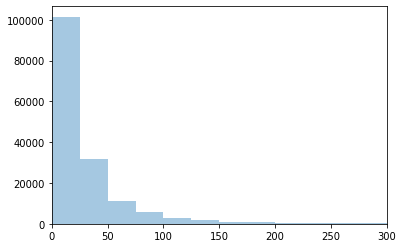

In [19]:
# Check the distribution of sentence lengths to determine length of input
num_words = []
for entry in train_tokenized_x:
    num_words.append(len(entry))
fig, ax = plt.subplots()
sns.distplot(num_words, hist = True, kde = False)
ax.set_xlim(0,300)
plt.show()

In [20]:
# Pad input so that they are all of the same length
MAX_WORD = 150
padded_train_x = pad_sequences(train_tokenized_x, maxlen = MAX_WORD)
padded_test_x = pad_sequences(test_tokenized_x, maxlen = MAX_WORD)
padded_train_x

array([[    0,     0,     0, ...,    57,    12,  3256],
       [    0,     0,     0, ...,   697,  7265,    87],
       [    0,     0,     0, ...,  2166,   567,   348],
       ...,
       [    0,     0,     0, ...,  3302, 13213,  4294],
       [    0,     0,     0, ...,   263,    54,    61],
       [    0,     0,     0, ...,   238,  1411,  1589]], dtype=int32)

In [21]:
import gensim

# Use gensim to load GoogleNews pre-trained word embeddings
INPUT_FILE = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(INPUT_FILE, binary=True)

In [22]:
# Convert gensim object into a python dictionary
dict_size = len(tokenizer.word_index)
embedding_index = {}
for word in word2vec.wv.vocab:
    embedding_index[word] = word2vec.word_vec(word)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [23]:
# Check to see if there is any common word that will not be factored into model because of issues with embeddings
set_word = set()
for row in train_cleaned_x:
    for word in row:
        set_word.add(word)
not_in = []
for word in set_word:
    if word not in embedding_index:
        not_in.append(word)
not_in

['wwwcircumcisionorg',
 'sangharaj',
 'cureently',
 'wisconsinwhitewater',
 'canyouhearmenow',
 'fyromnor',
 'propaedo',
 '11851200',
 'introit',
 'tubman',
 'springloaded',
 'halliburtons',
 '1753',
 'beatriz',
 'islandsyes',
 'majorinos',
 'redwolf24',
 'elss',
 'vol29',
 'gtalondon',
 'eytmology',
 '18441900',
 'euphrates',
 'harnack',
 'qho',
 'amandajm',
 'nlcategoriejiddisch',
 'hujsmodi',
 'initate',
 'telu',
 'wpaspersions',
 'filepachygrapsus',
 'southerneuropean',
 'stringerone',
 'regared',
 'editirial',
 'anglocentric',
 'tthus',
 'nadujpeg',
 'propagabda',
 'maupassant',
 'autrey',
 'webforums',
 'prelinguistic',
 'numberspaceunit',
 'webccsuedu',
 'wongfu',
 'perfroming',
 'otgrtype',
 'programit',
 '2show',
 'atach',
 'laudahnredirect',
 'loger',
 'esb',
 'mosar',
 'vendetta87the',
 '24p',
 'openandshut',
 'amercias',
 'wwwworkingforchangecom',
 '3777752spn',
 'it17317422248',
 'moneywhoopssorry',
 'ensurance',
 '8tops',
 'krw',
 'greetings2486116250',
 'wpcivility',
 't

In [24]:
# Create a matrix of embeddings and pick the default values from the distribution of matrix weights
embeddings = np.stack(list(embedding_index.values())) # 3,000,000 by 300
embeddings_mean = embeddings.mean()
embeddings_std_dev = embeddings.std()
embedding_matrix = np.random.normal(embeddings_mean, embeddings_std_dev, (len(tokenizer.word_index), EMBEDDING_SIZE)) # 20,000 by 300

In [25]:
# For words from the source text (fed into the tokenizer), change the weights in the matrix to match their embedding values
for word, index in tokenizer.word_index.items():
    if word in embedding_index:
        embedding_matrix[index - 1] = embedding_index[word]

In [38]:
# Import model and layers used
from keras.models import Model
from keras.layers import  Embedding, Input, concatenate, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional, LSTM, Dense


# Use keras to define model
emb = Input(shape=(None,))
feat_eng = Input(shape=(2,))
x = Embedding(dict_size,embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(emb)

x = SpatialDropout1D(0.2)(x)        
# Drop 1D Features of input matrix (i.e. row)

x = Bidirectional(LSTM(100, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))(x)
# dropout = drop linear transformation of input
# recurrent_dropout = drop linear transformation of recurrent state
# return full hidden state output

x = GlobalMaxPooling1D()(x)
# To be location invariant

x = concatenate([feat_eng, x])
# Factor in numerical features and text

x = Dense(6, activation = "sigmoid")(x)
# Sigmoid encourages output components to be independent of each other (with softmax one high logit would push others lower)

model = Model([feat_eng, emb], x)
model.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics = ['accuracy'])


In [33]:
# Fit model on our padded data
classifier = model.fit([train_x_eng,padded_train_x], train_y.values, batch_size = 1024, epochs = 5, validation_split = 0.1)

Epoch 1/5
141/141 [==============================] - 137s 970ms/step - loss: 0.1680 - accuracy: 0.9741 - val_loss: 0.1450 - val_accuracy: 0.9939
Epoch 2/5
141/141 [==============================] - 133s 947ms/step - loss: 0.1379 - accuracy: 0.9937 - val_loss: 0.1231 - val_accuracy: 0.9940
Epoch 3/5
141/141 [==============================] - 135s 957ms/step - loss: 0.1158 - accuracy: 0.9926 - val_loss: 0.0998 - val_accuracy: 0.9929
Epoch 4/5
141/141 [==============================] - 136s 962ms/step - loss: 0.0953 - accuracy: 0.9930 - val_loss: 0.0865 - val_accuracy: 0.9933
Epoch 5/5
141/141 [==============================] - 136s 963ms/step - loss: 0.0829 - accuracy: 0.9938 - val_loss: 0.0753 - val_accuracy: 0.9939


In [34]:
# Predict outcomes for our test data and save as a csv
prediction = model.predict( [test_x_eng, padded_test_x], batch_size = 1024)
sample_submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = prediction
sample_submission.to_csv('submission.csv', index = False)


Next Steps & Potential Changes:

1. Tuning Parameters
2. Experimenting with Architecture
3. Experimenting with different word embeddings (i.e. FastText)
4. Assessing model performance